> # Visualisations

In [ ]:
%load_ext autoreload
%autoreload 2

import sys
import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import statsmodels.api as sm
from statsmodels.regression.mixed_linear_model import MixedLM


sys.path.append('src')

from coeff_importance import plot_region_coefficients, plot_region_indv_coefficients
from cooks_distance import analyze_region_outliers
from hetroskedasticity import plot_single_region_residuals
from icc_r2 import plot_variance_components, plot_combined_metrics
from normality import get_axis_limits, plot_single_region_qq

warnings.filterwarnings("ignore")


In [ ]:
# Set global defaults using rcParams
plt.rcParams["figure.figsize"] = (6, 4)
plt.rcParams["axes.labelsize"] = 14
plt.rcParams["axes.labelweight"] = "bold"
plt.rcParams["axes.labelpad"] = 8
plt.rcParams["xtick.labelsize"] = 12
plt.rcParams["xtick.major.pad"] = 8
plt.rcParams["ytick.labelsize"] = 12
plt.rcParams["axes.titleweight"] = "bold"
plt.rcParams["figure.autolayout"] = True
plt.rcParams["legend.fontsize"] = 12

plt.rcParams["legend.edgecolor"] = 'black'

In [ ]:
y = pd.read_csv("data/conflicts/Y_conflicts.csv")
x = pd.read_csv("data/political identities/X.csv")
#Drop NA Average Term Population
x = x.dropna(subset=['Average Term Population'])

In [ ]:
# Merging the two df
df = pd.merge(x, y, left_on = ['country_name', 'year','end_year'], right_on = ['country', 'start_year','end_year'], how = 'right')
df.dropna(inplace=True)

df_all = df.copy()

# Remove the regions Western Europe and North America and Eastern Europe and Central Asia 
df = df.loc[~df['region'].isin(['Western Europe and North America', 'Eastern Europe and Central Asia'])]

In [5]:
# Consider counries with more than 2 observations
country_counts = df['country_name'].value_counts()

multiple_obs_countries = country_counts[country_counts > 2].index

df_filtered = df[df['country_name'].isin(multiple_obs_countries)]

In [ ]:
# Natural breaks for year using natural breaks algorithm
from jenkspy import jenks_breaks

breaks = jenks_breaks(df_filtered['end_year'],4)

bins = pd.cut(df_filtered['year'], bins=[1988,2000,2008,2015,2023], labels=['1989 - 2000', '2001 - 2008', '2009 - 2015', '2016- 2023'])

df_filtered['era'] = bins

In [7]:
breaks

[np.int64(1991),
 np.int64(2000),
 np.int64(2008),
 np.int64(2015),
 np.int64(2023)]

In [8]:
df_filtered.era.unique()

['1989 - 2000', '2001 - 2008', '2009 - 2015', '2016- 2023']
Categories (4, object): ['1989 - 2000' < '2001 - 2008' < '2009 - 2015' < '2016- 2023']

In [9]:
polarization_columns = [
    'Anti-Elitism Polarization', 'People-Centrism Polarization',
    'Political Opponents Polarization', 'Political Pluralism Polarization',
    'Minority Rights Polarization', 'Rejection of Political Violence Polarization',
    'Immigration Polarization', 'LGBT Social Equality Polarization',
    'Cultural Superiority Polarization', 'Religious Principles Polarization',
    'Gender Equality Polarization', 'Working Women Polarization',
    'Economic Left-Right Scale Polarization', 'Welfare Polarization',
    'Clientelism Polarization'
]
control_variables = ['Average Term Population', 'period_length',
       'Freedom of Expression', 'Religious Freedom', 'GDP per Capita',
       'Gini Index']

dependent_variables = ['events_rate','deaths_rate']

predictors = polarization_columns + control_variables

### Data Prep for Mixed Effects Nested Structure (Used in Cook's Distance Plots)

In [11]:
def prepare_data(df, prediction_column, predictors, region=None):
    """
    Prepare data for multilevel modeling
    """
    data = df.copy()

    if region!=None:
        data = data[data['Region'] == region]

    data.reset_index(inplace=True)
    
    # # Standardize numeric predictors
    # for col in predictors:
    #     if data[col].dtype in ['int64', 'float64']:
    #         data[col] = (data[col] - data[col].mean()) / data[col].std()
    
    # Standardize response variable
    # data[prediction_column] = (data[prediction_column] - data[prediction_column].mean()) / data[prediction_column].std()

    data['country_id'] = pd.Categorical(data['country_name']).codes
    data['era_id'] = pd.Categorical(data['era']).codes
    
    # Create unique identifiers for each level
    if region==None:
        data['region_id'] = pd.Categorical(data['Region']).codes
        # Create nested grouping identifiers
        data['country_region'] = data['country_id'].astype(str) + "_" + data['region_id'].astype(str)
    

    # Create nested grouping identifiers
    data['era_country'] = data['era_id'].astype(str) + "_" + data['country_id'].astype(str)
    
    return data.dropna(subset=[prediction_column] + predictors)

### Read Mixed Effects Region-wise Model Results

In [ ]:
import pickle

with open('data/modelling/region_nested_models_events.pkl', 'rb') as f:
    results_events = pickle.load(f)

with open('data/modelling/region_nested_models_deaths.pkl', 'rb') as f:
    results_deaths = pickle.load(f)

# MAIN - Coeff Checks

### All Regions in One

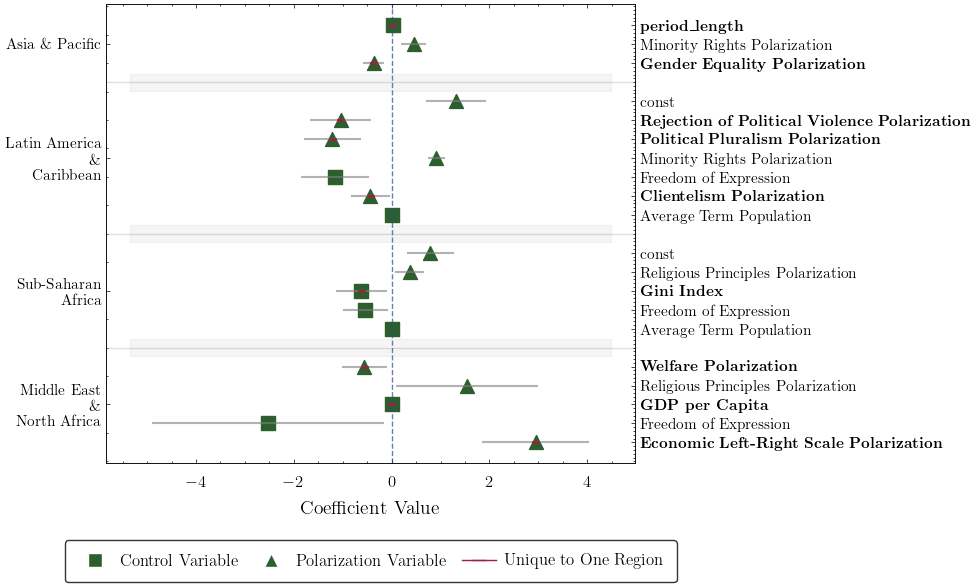

In [ ]:
fig = plot_region_coefficients(results_events, control_variables)
# grid off for both x and y
plt.grid(False)
# plt.grid(False)

# plt.savefig('assets/figs/region_all_coefficients_events.pdf', bbox_inches='tight')
plt.show()

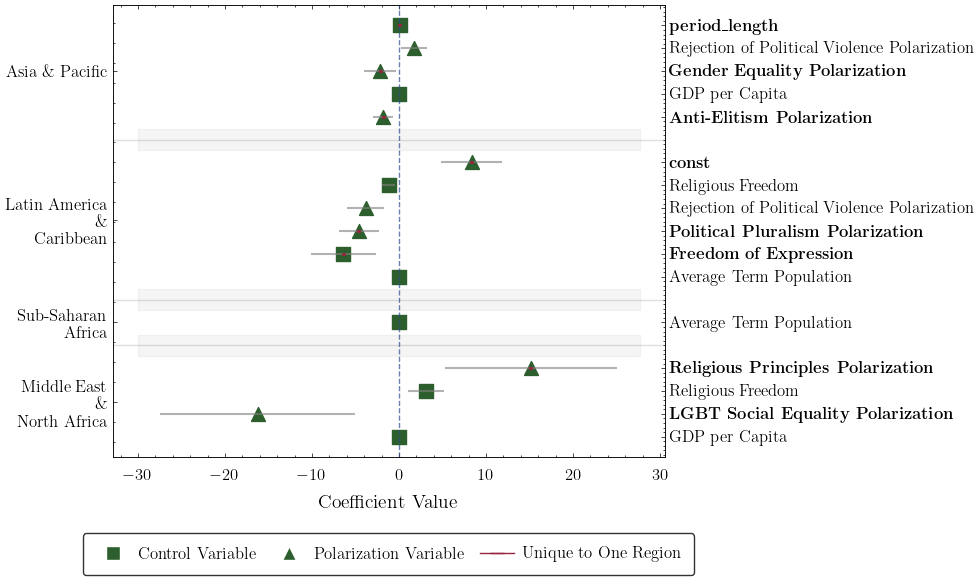

In [ ]:
fig = plot_region_coefficients(results_deaths, control_variables)
# grid off for both x and y
plt.grid(False)
# plt.grid(False)
plt.savefig('assets/figs/region_all_coefficients_deaths.pdf', bbox_inches='tight')
plt.show()

### ICC and R Square

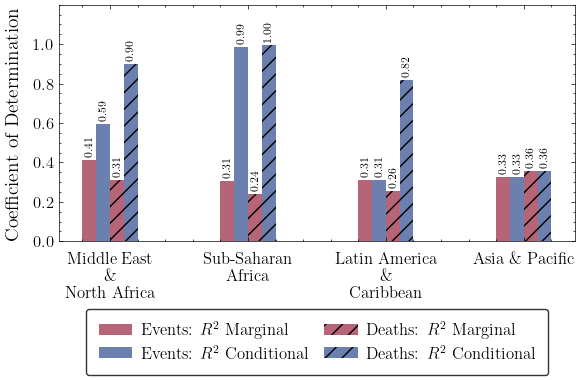

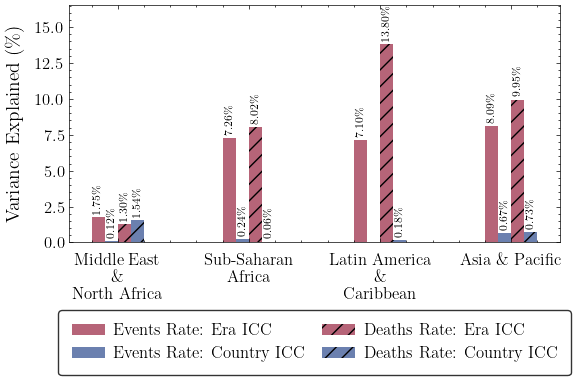

In [ ]:
fig_r2, fig_icc = plot_combined_metrics(results_events, results_deaths)
plt.show()

In [15]:
# Create the plots outside the function
y, height, colors, region_labels, era_iccs, country_iccs, r2_marginals, r2_conditionals, r2_adjusted, add_value_labels, style_axis = plot_variance_components(results_events)

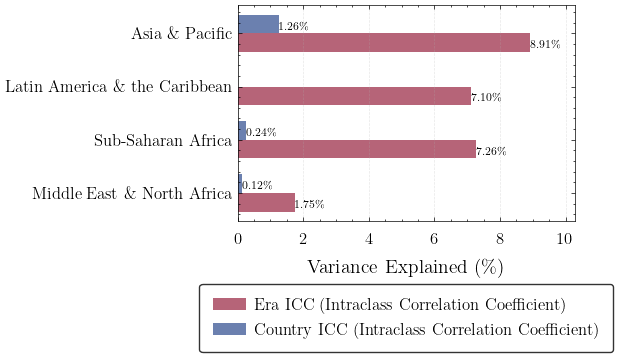

In [ ]:
# First plot - ICC values
plt.figure(figsize=(6, 4))
bars1 = plt.barh(y - height/2, era_iccs, height, label='Era ICC (Intraclass Correlation Coefficient)', color=colors[0], alpha=0.7)
bars2 = plt.barh(y + height/2, country_iccs, height, label='Country ICC (Intraclass Correlation Coefficient)', color=colors[1], alpha=0.7)

plt.xlabel('Variance Explained (\%)')
plt.yticks(y, region_labels)

add_value_labels(plt.gca(), bars1)
add_value_labels(plt.gca(), bars2)
style_axis(plt.gca(), ncol=1)
plt.tight_layout()

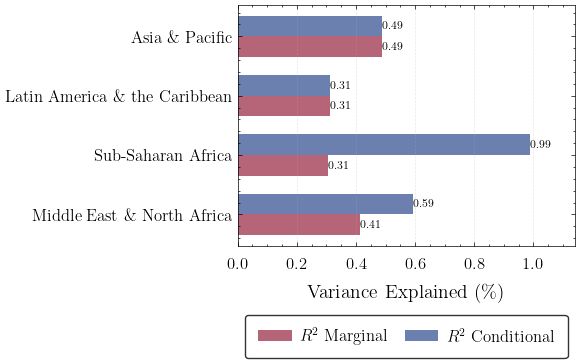

In [ ]:
# Second plot - R² values
plt.figure(figsize=(6, 4))
bars3 = plt.barh(y - height/2, r2_marginals, height, label=r'$R^2$ Marginal', color=colors[0], alpha=0.7)
bars4 = plt.barh(y + height/2, r2_conditionals, height, label=r'$R^2$ Conditional', color=colors[1], alpha=0.7)

plt.xlabel('Variance Explained (\%)')
plt.yticks(y, region_labels)

add_value_labels(plt.gca(), bars3, r=True)
add_value_labels(plt.gca(), bars4, r=True)
style_axis(plt.gca(),ncol=2)

plt.tight_layout()

# Robust Ness Checks

### Homoscedasticity and Linearity of Residuals

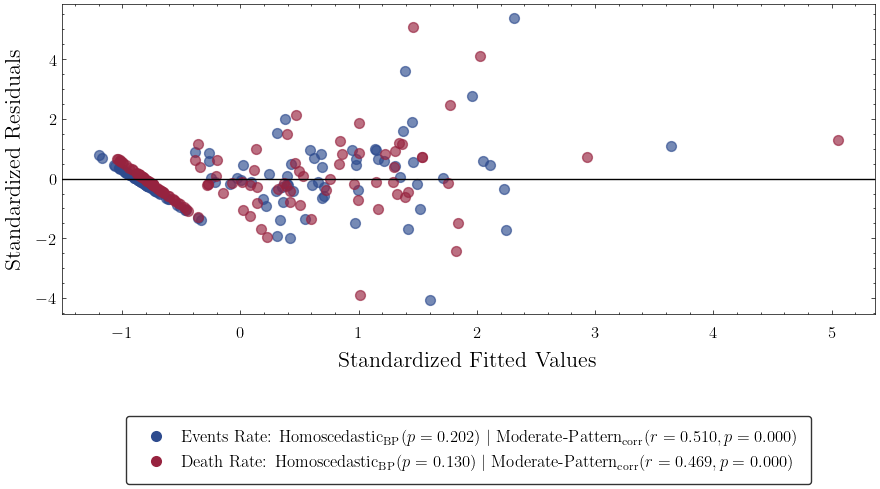

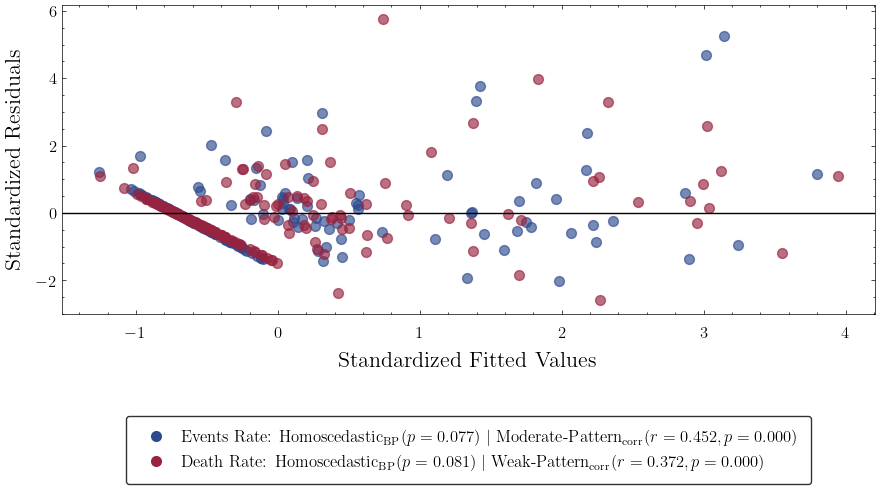

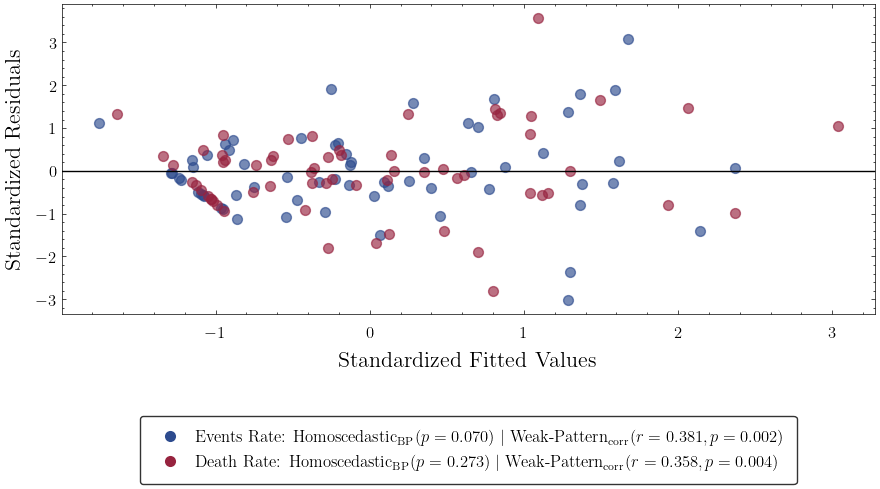

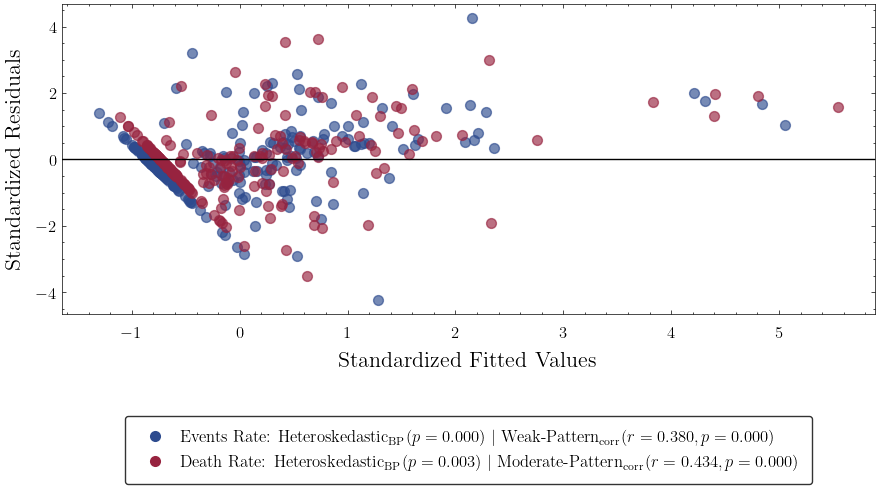

In [ ]:
region_order = [
    'Asia and Pacific',
    'Latin America and the Caribbean',
    'Middle East and North Africa',
    'Sub-Saharan Africa',
]

for region in region_order:
    fig = plot_single_region_residuals(
        results_events[region], 
        results_deaths[region], 
    )
    plt.grid(False)
    plt.tight_layout()
    plt.savefig(f'assets/figs/hetro_linearity/{region}_residuals.pdf', bbox_inches='tight')
    plt.show()

### Cooks Distance for Residual Outlier Detection


In [118]:
ios= df_filtered[(df_filtered.country_name == 'Sri Lanka') & (df_filtered.era == '2001 - 2008')].index.values

df_filtered.drop(ios,axis='index',inplace=True)

Analyzing outliers for events rate

Analyzing outliers for Middle East and North Africa
------------------------------------------------


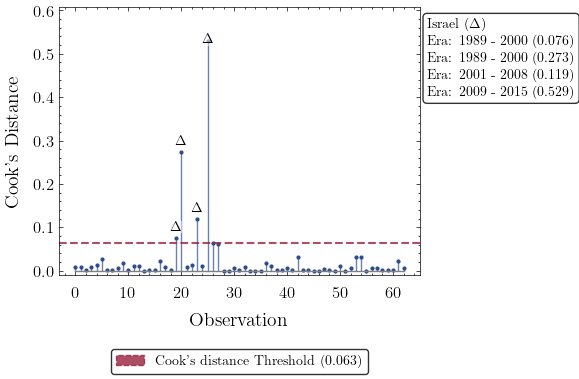


Outliers in Middle East and North Africa:
    country          era  cooks_distance
25        4  2009 - 2015        0.528960
20        4  1989 - 2000        0.273449
23        4  2001 - 2008        0.118626
19        4  1989 - 2000        0.075946

Analyzing outliers for Sub-Saharan Africa
--------------------------------------


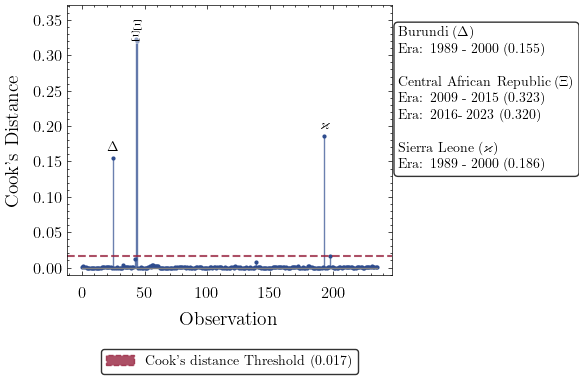


Outliers in Sub-Saharan Africa:
     country          era  cooks_distance
43         7  2009 - 2015        0.323061
44         7   2016- 2023        0.320066
193       34  1989 - 2000        0.186374
25         4  1989 - 2000        0.155293

Analyzing outliers for Latin America and the Caribbean
---------------------------------------------------


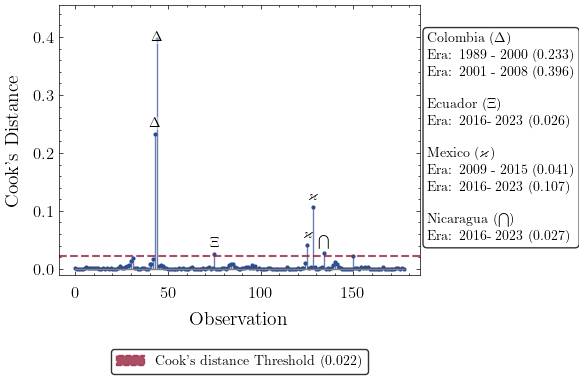


Outliers in Latin America and the Caribbean:
     country          era  cooks_distance
44         4  2001 - 2008        0.396273
43         4  1989 - 2000        0.232697
128       14   2016- 2023        0.107054
125       14  2009 - 2015        0.040585
134       15   2016- 2023        0.027169
75         7   2016- 2023        0.025546

Analyzing outliers for Asia and Pacific
------------------------------------


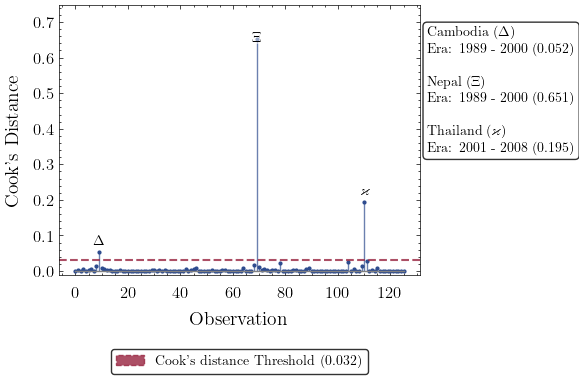


Outliers in Asia and Pacific:
     country          era  cooks_distance
69        10  1989 - 2000        0.650871
110       16  2001 - 2008        0.195064
9          2  1989 - 2000        0.052334


In [ ]:
def run_outlier_analysis(results_dict, df, predictors, prediction_column):
    for region, results in results_dict.items():
        print(f"\nAnalyzing outliers for {region}")
        print("-" * (20 + len(region)))
        
        results['prediction_column'] = prediction_column
        results['region'] = region
        
        region_data = prepare_data(df, prediction_column, predictors, region)
        
        # Run outlier analysis
        outlier_analysis = analyze_region_outliers(results, region_data, predictors)
        
        if outlier_analysis:
            plt.figure(outlier_analysis['plot'].number)
            plt.savefig(f'assets/figs/{region}_events_rate_outliers.pdf', bbox_inches='tight')
            plt.show()
            
            # Print outlier details
            outliers = outlier_analysis['analysis']['results_df'][
                outlier_analysis['analysis']['results_df']['is_outlier']
            ]
            if len(outliers) > 0:
                print(f"\nOutliers in {region}:")
                print(outliers[['country', 'era', 'cooks_distance']].sort_values('cooks_distance', ascending=False))
            else:
                print(f"\nNo outliers detected in {region}")
                
            plt.close() 

print("Analyzing outliers for events rate")
run_outlier_analysis(results_events, df_filtered, predictors, 'events_rate')

### Normality of residuals QQ Plots

In [ ]:

region_order = df_filtered.region.unique()

axis_limits = get_axis_limits(results_events, results_deaths, region_order)

for region in region_order:
    fig = plot_single_region_qq(
        results_events[region], 
        results_deaths[region], 
        region,
        axis_limits
    )

    plt.grid(False)
    plt.savefig(f'assets/figs/{region}_qq_plot.pdf', bbox_inches='tight')
    plt.show()

# Global Map Visualisation

**Dataset Link:** https://github.com/nvkelso/natural-earth-vector/tree/master/geojson (GeoJson)

In [ ]:
import pandas as pd
import numpy as np
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import LinearSegmentedColormap, Normalize

In [ ]:
y = pd.read_csv("data/conflicts/Y_conflicts.csv")
x = pd.read_csv("data/political identities/X.csv")

x = x.dropna(subset=['Average Term Population'])
df = pd.merge(x, y, left_on = ['country_name', 'year','end_year'], right_on = ['country', 'start_year','end_year'], how = 'right')

In [ ]:
world = gpd.read_file('data/world map/ne_110m_admin_0_countries.shp')

# Remove Antarctica
world = world[world['CONTINENT'] != 'Antarctica']
world_data = world.merge(df, left_on='SOVEREIGNT', right_on='country_name', how='left')


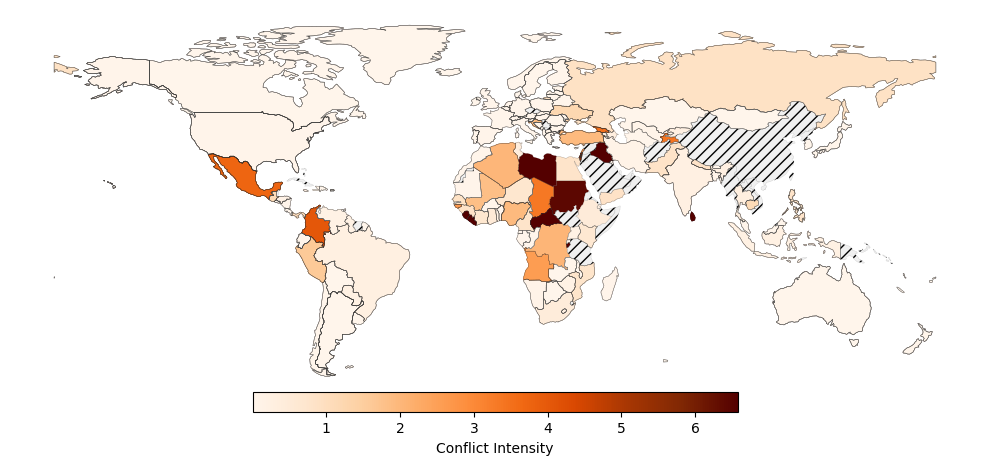

In [ ]:
# Calculate average rates
world_data['mean_events_rate'] = world_data.groupby('SOVEREIGNT')['events_rate'].transform('mean')
world_data['mean_death_rate'] = world_data.groupby('SOVEREIGNT')['deaths_rate'].transform('mean')
world_data['conflict_intensity'] = world_data['mean_death_rate'] * world_data['mean_events_rate']


colors = [
    '#fff5eb',  # Lightest
    '#fee6ce',
    '#fdd0a2',
    '#fdae6b',
    '#fd8d3c',
    '#f16913',
    '#d94801',
    '#a63603',
    '#7f2704',   # Darkest
    '#540000'  
]
custom_cmap = LinearSegmentedColormap.from_list('custom', colors, N=256)

fig, ax = plt.subplots(1, 1, figsize=(10, 5), facecolor='white')
fig.patch.set_facecolor('white')
ax.set_facecolor('#f8f9fa')


data = world_data['mean_death_rate']
data_nonzero = data[data > 0]
vmin = data_nonzero.min()
vmax = data.max()
norm = Normalize(vmin=vmin, vmax=vmax * 0.35)  # more intense colors

world_data.plot(column='mean_death_rate',
                cmap=custom_cmap,
                norm=norm,
                legend=True,
                legend_kwds={
                    'label': 'Conflict Intensity',
                    'orientation': 'horizontal',
                    'shrink': 0.5,
                    'aspect': 25,
                    'pad': 0.01,
                    'fraction': 0.1,
                },
                missing_kwds={
                    'color': '#f0f0f0',
                    'hatch': '///',
                    'label': 'No Data'
                    
                },
                ax=ax)


ax.axis('off')
world_data.boundary.plot(ax=ax, linewidth=0.3, color='#363636', alpha=0.2)
ax.set_ylim([-60, 90])  # Adjusted latitude range
plt.tight_layout()

plt.savefig('assets/figs/enhanced_conflict_map.pdf', 
            dpi=300, 
            bbox_inches='tight', 
            facecolor='white',
            edgecolor='none')

plt.show()

# EDA Appendix

# Other

### Stationarity Test

In [ ]:
# ADF Test for stationarity for scaled_df polarization columns, control variables and interactions
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import kpss

In [ ]:
results = {}

# Calculate region-wise stationarity
for region in df_filtered['region'].unique():
    results[region] = {}
    region_data = df_filtered[df_filtered['region'] == region]
    for col in polarization_columns + control_variables:
        series = region_data[col]
        adf_result = adfuller(series, autolag='AIC')
        kpss_result = kpss(series, regression='c')
        results[region][col] = adf_result[1] < 0.05 

stationarity_results = pd.DataFrame(results)


In [ ]:
stationarity_results

,Middle East and North Africa,Sub-Saharan Africa,Latin America and the Caribbean,Asia and Pacific
Anti-Elitism Polarization,False,True,True,True
People-Centrism Polarization,True,True,True,True
Political Opponents Polarization,True,True,True,True
Political Pluralism Polarization,True,True,True,True
Minority Rights Polarization,True,True,True,True
Rejection of Political Violence Polarization,True,True,True,True
Immigration Polarization,True,True,True,True
LGBT Social Equality Polarization,True,False,True,True
Cultural Superiority Polarization,True,True,True,True
Religious Principles Polarization,False,True,True,True


In [ ]:
# False / False + True
stationarity_results.sum().sum() / (stationarity_results.shape[0] * stationarity_results.shape[1])

np.float64(0.8809523809523809)

In [ ]:
adf_result

(np.float64(-1.8758048054874954),
 np.float64(0.3435274813854474),
 7,
 119,
 {'1%': np.float64(-3.4865346059036564),
  '5%': np.float64(-2.8861509858476264),
  '10%': np.float64(-2.579896092790057)},
 np.float64(711.5896743778374))

### Cointegration Test

In [ ]:
from statsmodels.tsa.stattools import coint

def pairwise_cointegration_test(df, alpha=0.05, region_column=None):
    def perform_pairwise_test(subset, region=None):
        variables = subset.columns
        results = []
        
        # Perform pairwise cointegration tests
        for i in range(len(variables)):
            for j in range(i + 1, len(variables)):
                col1, col2 = variables[i], variables[j]
                stat, p_value, _ = coint(subset[col1], subset[col2])
                
                results.append({
                    'Variable 1': col1,
                    'Variable 2': col2,
                    'Test Statistic': stat,
                    'P-Value': p_value,
                    'Significant': p_value < alpha,
                    'Region': region
                })
        
        return pd.DataFrame(results)
    
    if region_column and region_column in df.columns:
        all_results = []
        for region, group in df.groupby(region_column):
            subset = group.drop(columns=[region_column])
            result = perform_pairwise_test(subset, region=region)
            all_results.append(result)
        return pd.concat(all_results, ignore_index=True)
   
    return perform_pairwise_test(df)


# Perform pairwise cointegration tests
coint_df = pairwise_cointegration_test(df_filtered[predictors + ['deaths_rate', 'events_rate']], region_column='Region')

In [ ]:
# data where at least Variable 1 or Variable 2 is events_rate or deaths_rate
coint_df[(coint_df['Variable 1'].isin(['events_rate', 'deaths_rate'])) | (coint_df['Variable 2'].isin(['events_rate', 'deaths_rate']))].Significant.value_counts()

Significant
True    43
Name: count, dtype: int64

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import textwrap

# Define Global North and South regions
GLOBAL_NORTH = ['Western Europe and North America', 
                'Eastern Europe and Central Asia']
GLOBAL_SOUTH = ['Middle East and North Africa', 
                'Sub-Saharan Africa', 
                'Latin America and the Caribbean', 
                'Asia and Pacific']

plt.style.use(['science'])
plt.rcParams["figure.figsize"] = (10, 6)
plt.rcParams["axes.labelsize"] = 14
plt.rcParams["axes.labelweight"] = "bold"
plt.rcParams["axes.labelpad"] = 8
plt.rcParams["xtick.labelsize"] = 12
plt.rcParams["ytick.labelsize"] = 12
plt.rcParams["axes.titleweight"] = "bold"
plt.rcParams["figure.autolayout"] = True
plt.rcParams["legend.fontsize"] = 12
plt.rcParams["legend.edgecolor"] = 'black'

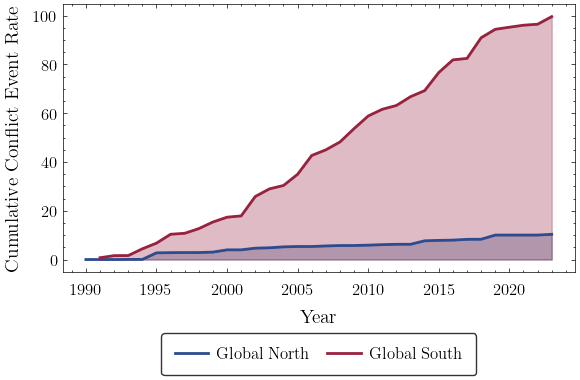

In [ ]:
def plot_cumulative_comparison(df):
    fig = plt.figure(figsize=(6, 4))
    
    # Calculate cumulative deaths for North and South
    north_data = df[df['Region'].isin(GLOBAL_NORTH)].groupby('end_year')['events_rate'].sum().cumsum()
    south_data = df[df['Region'].isin(GLOBAL_SOUTH)].groupby('end_year')['events_rate'].sum().cumsum()

    plt.plot(north_data.index, north_data.values, 
             color='#2D4B8E', linewidth=2, label='Global North')
    plt.plot(south_data.index, south_data.values, 
             color='#97233F', linewidth=2, label='Global South')
    
    plt.fill_between(north_data.index, north_data.values, 
                     alpha=0.3, color='#2D4B8E')
    plt.fill_between(south_data.index, south_data.values, 
                     alpha=0.3, color='#97233F')
    
    plt.xlabel("Year")
    plt.ylabel("Cumulative Conflict Event Rate")
    
    leg = plt.legend(bbox_to_anchor=(0.5, -0.2),
                    loc='upper center',
                    ncol=2,
                    frameon=True,
                    borderpad=0.8,
                    handletextpad=0.5,
                    columnspacing=1.0)
    

    plt.subplots_adjust(bottom=0.35)
    
    return fig

plot_cumulative_comparison(df_all)
plt.savefig('assets/figs/cumulative_events_comparison.pdf', bbox_inches='tight')
plt.show()

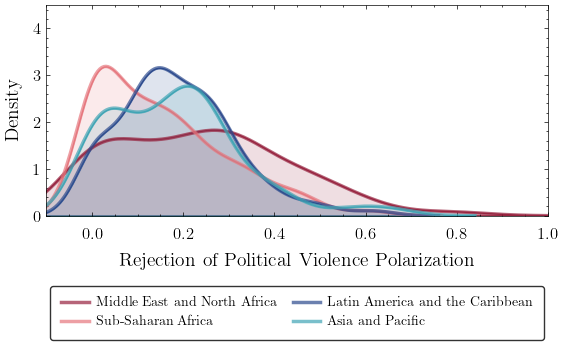

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Set the style parameters
plt.style.use(['science'])
plt.rcParams["figure.figsize"] = (10, 6)
plt.rcParams["axes.labelsize"] = 14
plt.rcParams["axes.labelweight"] = "bold"
plt.rcParams["axes.labelpad"] = 8
plt.rcParams["xtick.labelsize"] = 12
plt.rcParams["ytick.labelsize"] = 12
plt.rcParams["axes.titleweight"] = "bold"
plt.rcParams["figure.autolayout"] = True
plt.rcParams["legend.fontsize"] = 10
plt.rcParams["legend.edgecolor"] = 'black'

def plot_religious_polarization(df_filtered):
    fig = plt.figure(figsize=(6, 4))
    
    colors = {
        'Middle East and North Africa': '#97233F',      # Original burgundy
        'Sub-Saharan Africa': '#E6777E',               # Coral pink
        'Latin America and the Caribbean': '#2D4B8E',  # Original blue
        'Asia and Pacific': '#40A5B5'                  # Teal
    }

    for region in df_filtered['Region'].unique():
        data = df_filtered[df_filtered['Region'] == region]['Rejection of Political Violence Polarization']
        
        sns.kdeplot(data=data, 
                   label=region,
                   color=colors[region],
                   linewidth=2.5,
                   alpha=0.7)
        
        sns.kdeplot(data=data,
                   color=colors[region],
                   alpha=0.15,
                   fill=True)
    
    plt.xlabel("Rejection of Political Violence Polarization")
    plt.ylabel("Density")


    leg = plt.legend(bbox_to_anchor=(0.5, -0.3),
                    loc='upper center',
                    ncol=2,
                    frameon=True,
                    borderpad=0.8,
                    handletextpad=0.5,
                    columnspacing=1.0)

    plt.xlim(-0.1, 1.0)
    plt.ylim(0, 4.5)

    plt.tight_layout()
    return fig

plot_religious_polarization(df_filtered)
plt.savefig('assets/figs/rejection_viollence_polarization_distribution.pdf', bbox_inches='tight')
plt.show()

In [58]:
# Normalise % of era-wise spread for eacah region

df_filtered.groupby('Region').era.value_counts(normalize=True)

Region                           era        
Asia and Pacific                 1989 - 2000    0.385827
                                 2001 - 2008    0.259843
                                 2009 - 2015    0.220472
                                 2016- 2023     0.133858
Latin America and the Caribbean  1989 - 2000    0.415730
                                 2001 - 2008    0.247191
                                 2009 - 2015    0.230337
                                 2016- 2023     0.106742
Middle East and North Africa     1989 - 2000    0.301587
                                 2001 - 2008    0.285714
                                 2009 - 2015    0.285714
                                 2016- 2023     0.126984
Sub-Saharan Africa               1989 - 2000    0.360169
                                 2001 - 2008    0.271186
                                 2009 - 2015    0.233051
                                 2016- 2023     0.135593
Name: proportion, dtype: float64

In [57]:
df_filtered.groupby('Region').country_name.nunique()

Region
Asia and Pacific                   19
Latin America and the Caribbean    22
Middle East and North Africa       11
Sub-Saharan Africa                 42
Name: country_name, dtype: int64

In [ ]:
# For each region the highest variance polarization variable
# Top 3 variances
df_filtered[polarization_columns + ['Region']].groupby('Region').var().T

Region,Asia and Pacific,Latin America and the Caribbean,Middle East and North Africa,Sub-Saharan Africa
Anti-Elitism Polarization,0.036129,0.036438,0.043638,0.042323
People-Centrism Polarization,0.020324,0.017077,0.020165,0.012786
Political Opponents Polarization,0.020046,0.032459,0.035905,0.029099
Political Pluralism Polarization,0.027737,0.018488,0.027352,0.020592
Minority Rights Polarization,0.027111,0.029834,0.036090,0.032781
Rejection of Political Violence Polarization,0.020998,0.015768,0.034923,0.020158
Immigration Polarization,0.015622,0.019102,0.032791,0.009105
LGBT Social Equality Polarization,0.022058,0.032115,0.028116,0.026736
Cultural Superiority Polarization,0.045626,0.022249,0.031015,0.022245
Religious Principles Polarization,0.040649,0.019584,0.027015,0.019407
